In [20]:
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import xgboost as xgb
import pprint as pp
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import bnp_helper
import common_helper
import random


In [2]:
train_df_raw = pd.read_csv("../data/train.csv")

In [6]:
train_df = bnp_helper.clean(train_df_raw, drop_collinearity = True, inplace = False)
train_df = bnp_helper.impute_cate_with_na_numeric_with_interpolate_linear(train_df_updated)


In [13]:
train_df = common_helper.dummify(train_df, bnp_helper.get_categorical_variables(train_df))
train_df.head()

,ID,target,v1,v2,v4,v6,v7,v9,v10,v14,...,v125_Z,v129_1,v129_11,v129_2,v129_3,v129_4,v129_5,v129_6,v129_7,v129_8
0,3,1,1.335739,8.727474,3.921026,2.599278,3.176895,9.999999,0.503281,11.636387,...,0,0,0,0,0,0,0,0,0,0
1,4,1,1.139808,7.018777,4.165997,3.289435,3.552733,11.333333,1.312910,11.636386,...,0,0,0,0,0,0,0,0,0,0
2,5,1,0.943877,5.310079,4.410969,3.979592,3.928571,12.666667,0.765864,9.603542,...,0,0,0,1,0,0,0,0,0,0
3,6,1,0.797415,8.304757,4.225930,2.097700,1.987549,8.965516,6.542669,14.094723,...,0,1,0,0,0,0,0,0,0,0
4,8,1,0.831545,7.974170,3.982003,2.040490,1.915175,7.647440,1.050328,10.991098,...,1,0,0,0,0,0,0,0,0,0


In [23]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 12, 4


def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg_fit = alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    print alg_fit
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob[:,1])    
    print "Log Loss (Train): %f" % metrics.log_loss(dtrain['target'], dtrain_predprob)
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [3]:
#train_df = pd.read_csv("../data/cleaned/imputed_df_na_dummies_linear.csv")

#train_df_raw = pd.read_csv("../data/train.csv")

In [26]:
random.seed(0)
train_df_sample = train_df.sample(20000)

target = train_df_sample['target']
X_train = train_df_sample.drop(['ID', 'target'], axis = 1)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 37


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=38, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

Model Report
Accuracy : 0.7931
AUC Score (Train): 0.801561
Log Loss (Train): 0.441964


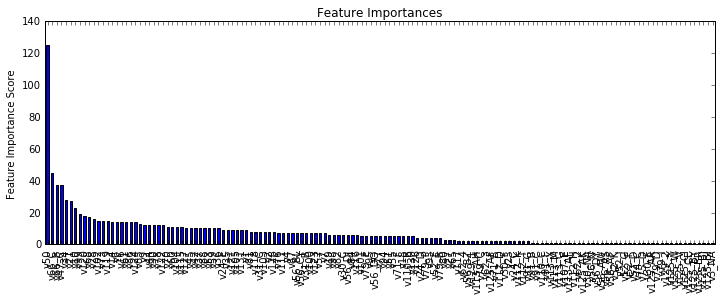

In [27]:
#Choose all predictors except target & IDcols
predictors = [x for x in train_df.columns if x not in ['ID', 'target']]
#print predictors

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

modelfit(xgb1, train_df_sample, predictors)

In [ ]:
    max_depth=5,
    min_child_weight=1,
    Log Loss (Train): 0.437753
        
     {'max_depth': 6, 'min_child_weight': 5}, -0.55280434320858529)
   
{'max_depth': 4, 'min_child_weight': 3},
 -0.51165867501226481)
    
     {'gamma': 0.2},
 -0.51026556093699826)

 {'gamma': 0.3},
 -0.5092754346052939)

{'colsample_bytree': 0.7, 'subsample': 0.9},
 -0.50763341622412728)
        

In [5]:
param_test1 = {
    'subsample':[i/10.0 for i in range(7,10)],
    'colsample_bytree':[i/10.0 for i in range(7,10)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=140, max_depth=4, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, target)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.51384, std: 0.00835, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.51184, std: 0.00807, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.50763, std: 0.00773, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.51582, std: 0.00993, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.50928, std: 0.00667, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.50987, std: 0.00698, params: {'subsample': 0.9, 'colsample_bytree': 0.8},
  mean: -0.51552, std: 0.00754, params: {'subsample': 0.7, 'colsample_bytree': 0.9},
  mean: -0.51191, std: 0.00487, params: {'subsample': 0.8, 'colsample_bytree': 0.9},
  mean: -0.50877, std: 0.00809, params: {'subsample': 0.9, 'colsample_bytree': 0.9}],
 {'colsample_bytree': 0.7, 'subsample': 0.9},
 -0.50763341622412728)

In [65]:

# XGBoost params:
xgboost_params = { 
    "objective": "binary:logistic",
    "booster": "gbtree",  # model type, tree-based or linear
    "eval_metric": "logloss",  #scoring metric: rmse,error,logloss,mlogloss,auc
    "eta": 0.1, # 0.06, #0.01, # learning rate
    "min_child_weight": 10,  # min number of observations in a node, be tunned
    "subsample": 0.75,   # number of rows, be tunned
    "colsample_bytree": 0.68,  # number of columns, be tunned
    "max_depth": 20,   # depth of tree, typical value 3-10, be tunned
    "gamma" : 0,    # min loss reduction to make a split, be tunned
    "seed": 0,
    "scale_pos_weight": 0 # > 0 value in case of high class imbalance
}

In [66]:
xgtrain = xgb.DMatrix(X_train.values, target.values)
xgtest = xgb.DMatrix(X_test.values, target_test.values)

# Fitting the model
print('Fit the model...')
boost_round = 100 #1800 CHANGE THIS BEFORE START
clf = xgb.train(xgboost_params,xgtrain,num_boost_round=boost_round,verbose_eval=True,maximize=False)

#eval(data, name='eval', iteration=0)
score = clf.eval(xgtest)

pp.pprint(score)

#Make predict
#print('Predict...')
#xgb_predict = clf.predict(xgtest, ntree_limit=clf.best_iteration)

# Save results
#predictions_file = open("simple_xgboost_result.csv", "w")
#open_file_object = csv.writer(predictions_file)
#open_file_object.writerow(["ID", "PredictedProb"])
#open_file_object.writerows(zip(ids, test_preds))
#predictions_file.close()
#
#print('Done.')


Fit the model...
'[0]\teval-logloss:0.472443'
